In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from keras.layers import Input, LSTM, RepeatVector,TimeDistributed,Dense,Lambda
from keras.models import Model
from keras.layers.merge import Concatenate
import keras.backend as K
from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
input_array=np.loadtxt("/content/drive/My Drive/Colab Notebooks/ECGFiveDays/ECGFiveDays_TEST.tsv")
np.random. seed (seed=5)
ts_array=np.random.shuffle(input_array)
ts_array=input_array[:,1:]
flag_array=input_array[:,0]


In [0]:
#ts_array-=np.min(ts_array)
#ts_array/=np.max(ts_array)


In [0]:
normal=(flag_array==1)
abnormal=(flag_array==2)
normal_ts=ts_array[normal]
abnormal_ts=ts_array[abnormal]

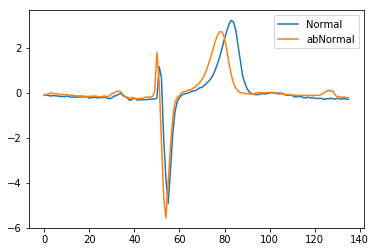

In [10]:
plt.plot(np.arange(136),normal_ts[92],label='Normal')
plt.plot(np.arange(136),abnormal_ts[92],label='abNormal')
plt.legend()

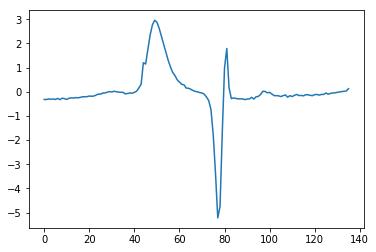

In [11]:

resversed_normal_ts=normal_ts[:,::-1]
normal_ts_shift=np.zeros(normal_ts.shape)
normal_ts_shift[:,1:]=normal_ts[:,:-1]
X=np.reshape(resversed_normal_ts,(428,136,1))
Y=np.reshape(normal_ts,(428,136,1))
X_decoder=np.reshape(normal_ts_shift,(428,136,1))
#X_tran=resversed_normal_ts[50:,:]
plt.plot(np.arange(136),resversed_normal_ts[2])

In [0]:
resversed_abnormal_ts=abnormal_ts[:,::-1]
abnormal_ts_shift=np.zeros(abnormal_ts.shape)
abnormal_ts_shift[:,1:]=abnormal_ts[:,:-1]
abX=np.reshape(resversed_abnormal_ts,(433,136,1))
abY=np.reshape(abnormal_ts,(433,136,1))
abX_decoder=np.reshape(abnormal_ts_shift,(433,136,1))

In [13]:

timesteps=136
input_dim=1
latent_dim=50
inputs = Input(shape=(timesteps, input_dim))
reverse_inp=K.reverse(inputs,axes=1)
A,_,C = LSTM(latent_dim,return_state = True)(inputs)
reverse_layer = Lambda(lambda x: K.reverse(x,axes=1),output_shape=(timesteps, input_dim))
reverse_inp=reverse_layer(inputs)
Ar,_,Cr = LSTM(latent_dim,return_state = True)(reverse_inp)
Ac=Concatenate(axis=1)([A, Ar])
Cc=Concatenate(axis=1)([C, Cr])
decode_input = Input(shape=(timesteps, input_dim))
decoded = LSTM(2*latent_dim, return_sequences=True)(decode_input,initial_state=[Ac, Cc])
output=TimeDistributed(Dense(1,activation='linear'),input_shape=(timesteps, 1))(decoded)
sequence_autoencoder = Model([inputs,decode_input], output)


In [14]:
sequence_autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
sequence_autoencoder.fit([X[80:],X_decoder[80:]], Y[80:],
                epochs=250,
                batch_size=16,
                shuffle=True,
                validation_data=(([abX,abX_decoder],abY)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 348 samples, validate on 433 samples
Epoch 1/250
348/348 [==============================] - 7s 20ms/step - loss: 0.8741 - val_loss: 0.7766
Epoch 2/250
348/348 [==============================] - 5s 13ms/step - loss: 0.6463 - val_loss: 0.5578
Epoch 3/250
348/348 [==============================] - 5s 15ms/step - loss: 0.4005 - val_loss: 0.2969
Epoch 4/250
348/348 [==============================] - 5s 14ms/step - loss: 0.2230 - val_loss: 0.1965
Epoch 5/250
348/348 [==============================] - 5s 14ms/step - loss: 0.1504 - val_loss: 0.1487
Epoch 6/250
348/348 [==============================] - 5s 14ms/step - loss: 0.1106 - val_loss: 0.1043
Epoch 7/250
348/348 [==============================] - 5s 14ms/step - loss: 0.0883 - val_loss: 0.0895
Epoch 8/250
348/348 [==============================] - 5s 14ms/step - loss: 0.0736 - val_loss: 0.0764
Epoch 9/250
348/348 [=====================

In [0]:
Y_predict=sequence_autoencoder.predict([X,X_decoder])

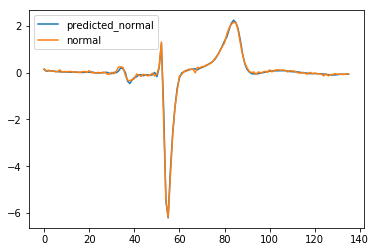

In [17]:
plt.plot(np.arange(136),Y_predict[0].flatten(),label='predicted_normal')
plt.plot(np.arange(136),Y[0].flatten(),label='normal')
plt.legend()

In [18]:
normal_mse=np.mean(np.square((Y_predict[:80]-Y[:80])),axis=1).flatten()
print(np.mean(normal_mse))

0.0049441231476515055


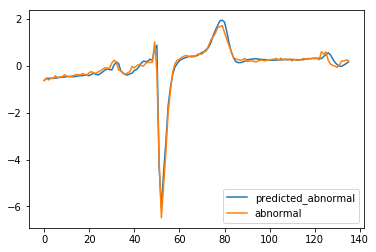

In [19]:

abY_predict=sequence_autoencoder.predict([abX,abX_decoder])
plt.plot(np.arange(136),abY_predict[100].flatten(),label='predicted_abnormal')
plt.plot(np.arange(136),abY[100].flatten(),label='abnormal')
plt.legend()

In [0]:
abnormal_mse=np.mean(np.square((abY_predict-abY)),axis=1).flatten()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


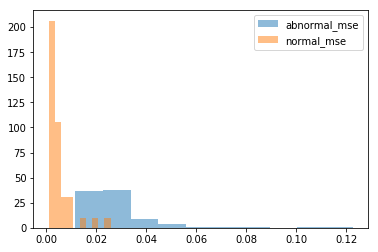

In [21]:
plt.hist(abnormal_mse,normed=True,alpha = 0.5,label='abnormal_mse')
plt.hist(normal_mse,normed=True,alpha = 0.5,label='normal_mse')
plt.legend()

In [22]:
print(len(normal_mse[normal_mse<0.0002])/len(normal_mse))
print(len(abnormal_mse[abnormal_mse>0.0002])/float(len(abnormal_mse)))

0.0
1.0


Calculate AUC score

In [23]:
#print(abnormal_mse.shape)
y_true=np.concatenate((np.zeros(len(normal_mse)),np.ones(len(abnormal_mse))))
y_score=np.concatenate((normal_mse,abnormal_mse))
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, y_score, average='macro')

0.977742494226328